In [2]:


import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# from PIL import Image
# import xml.etree.ElementTree as ET

In [2]:


#For model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


#For shwing images and graphs
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
extracted_folder_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/archive-2'
extracted_folder_path


'/content/drive/MyDrive/Colab Notebooks/255_Project/archive-2'

Images from CMFD (Correctly Masked Face Dataset):


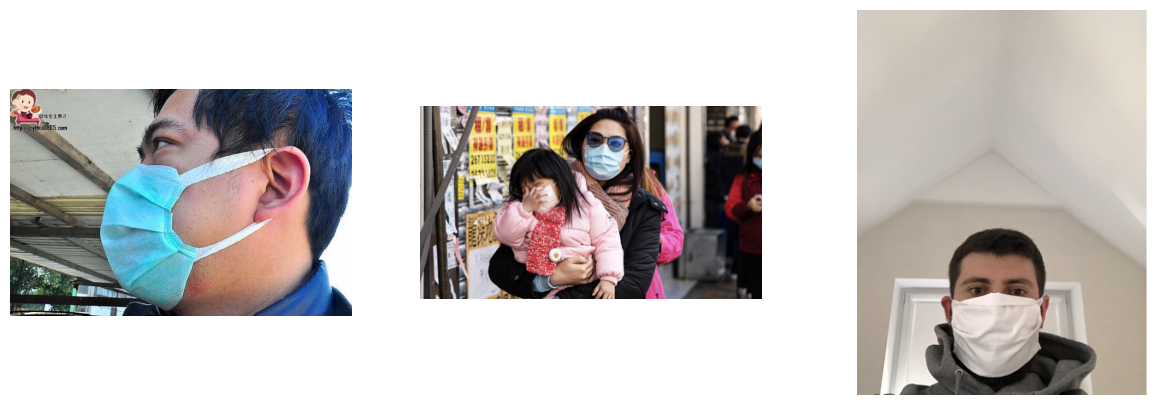

Images from IMFD (Incorrectly Masked Face Dataset):


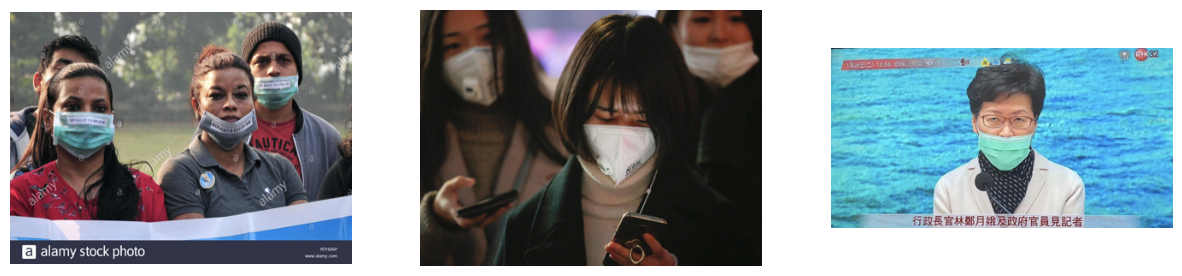

Images from No Mask:


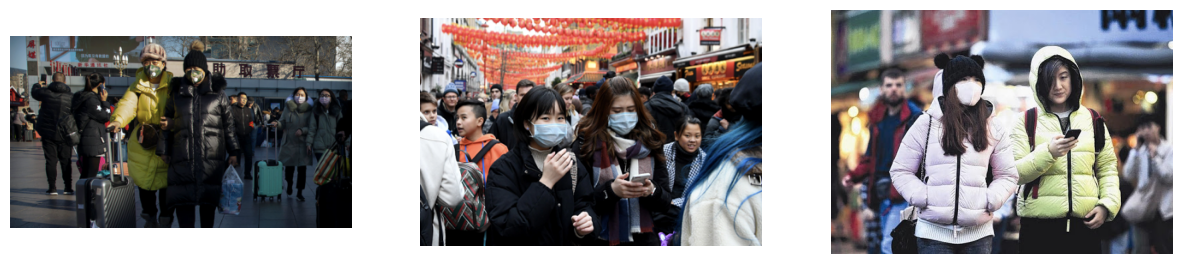

In [9]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display images
def display_images(folder_path, num_images=3):
    image_files = os.listdir(folder_path)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Displaying images from each category
print("Images from CMFD (Correctly Masked Face Dataset):")
display_images(f"{extracted_folder_path}/classes/with_mask")

print("Images from IMFD (Incorrectly Masked Face Dataset):")
display_images(f"{extracted_folder_path}/classes/mask_weared_incorrect")

print("Images from No Mask:")
display_images(f"{extracted_folder_path}/classes/without_mask")


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters for preprocessing
image_size = (64, 64)  # Standard size for the images
batch_size = 16        # Batch size for processing

# Setting up the ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,       # Normalizing the pixel values
    validation_split=0.2  # Splitting 20% data for validation
)

# Preparing the training and validation generators
train_generator = datagen.flow_from_directory(
    directory=f"{extracted_folder_path}/classes",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',   # Since we have two classes
    subset='training'      # Training data
)

validation_generator = datagen.flow_from_directory(
    directory=f"{extracted_folder_path}/classes",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',   # Since we have two classes
    subset='validation'    # Validation data
)

# Checking the class indices
class_indices = train_generator.class_indices
class_indices



Found 684 images belonging to 3 classes.
Found 169 images belonging to 3 classes.


{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [11]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Dense(1, activation='sigmoid')  # Binary classification
    Dense(3, activation='softmax')  # For three classes
])

In [12]:

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=2 # Adjust as necessary
)


Epoch 1/2
42/42 [==============================] - 554s 13s/step - loss: 0.8065 - accuracy: 0.7305 - val_loss: 0.6873 - val_accuracy: 0.7563
Epoch 2/2
42/42 [==============================] - 15s 353ms/step - loss: 0.7316 - accuracy: 0.7440 - val_loss: 0.6845 - val_accuracy: 0.7563


In [16]:
from tensorflow.keras.models import Model

# Define a new model to extract features
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense').output)

# Extract features for training data
train_features = feature_extractor.predict(train_generator)
train_labels = train_generator.classes

# Extract features for validation data
validation_features = feature_extractor.predict(validation_generator)
validation_labels = validation_generator.classes


11/11 [==============================] - 3s 248ms/step


# Train an SVM Classifier

In [17]:
from sklearn.svm import SVC

# Initialize an SVM classifier
svm_classifier = SVC(kernel='linear')  # You can use 'rbf' for a non-linear kernel

# Fit the SVM classifier on the training data
svm_classifier.fit(train_features, train_labels)

# Predict on the validation data
svm_predictions = svm_classifier.predict(validation_features)


# Evaluate the SVM Model

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(validation_labels, svm_predictions)
precision = precision_score(validation_labels, svm_predictions, average='weighted')
recall = recall_score(validation_labels, svm_predictions, average='weighted')
f1 = f1_score(validation_labels, svm_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7455621301775148
Precision: 0.5558628899548335
Recall: 0.7455621301775148
F1 Score: 0.6368869722194364


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test and Validate the Combined Model

In [24]:
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalizing the pixel values
)

test_generator = test_datagen.flow_from_directory(
    directory=f"{extracted_folder_path}/classes",  # Replace with the path to your test dataset
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Adjust class mode based on your problem
    shuffle=False  # Do not shuffle test data
)



Found 853 images belonging to 3 classes.


In [25]:
# Extract features for test data
test_features = feature_extractor.predict(test_generator)

# Predict with the SVM classifier
test_predictions = svm_classifier.predict(test_features)

# Evaluate the combined model
test_accuracy = accuracy_score(test_generator.classes, test_predictions)
test_precision = precision_score(test_generator.classes, test_predictions, average='weighted')
test_recall = recall_score(test_generator.classes, test_predictions, average='weighted')
test_f1 = f1_score(test_generator.classes, test_predictions, average='weighted')

print("Test Metrics for the Combined Model:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")


54/54 [==============================] - 17s 309ms/step
Test Metrics for the Combined Model:
Accuracy: 0.7432590855803048
Precision: 0.5524340682976709
Recall: 0.7432590855803048
F1 Score: 0.633794566587644


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
